# Environmental Data Analysis Pipeline

This notebook demonstrates a complete pipeline for analyzing environmental data from the 20th of February 2025 campaign with a pre-trained Keras model. The code performs the following tasks:

- **Data Loading:** Reads in CSV datasets containing environmental measurements and campaign data.
- **Model Inference:** Loads a pre-trained Keras model to predict environmental states for each data record.
- **Aggregation:** Aggregates the predictions over 2-minute intervals (by computing the mode of predicted classes and the average confidence).
- **Data Fusion:** Loads pollutant data and merges it with the model predictions.
- **Visualization:** Generates bar plots and time series plots to illustrate the relationships between the predicted states and pollutant values.

**Important:** To reproduce the code, you must download the required datasets and the pre-trained model from the following directories:
- Pre-trained model from: `/models`
- Datasets from: `dataset/Airquix_Data` and `dataset/Campaign_Dataset`

Below is the code to run the analysis pipeline:

Modell erfolgreich geladen. Yuhu.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms

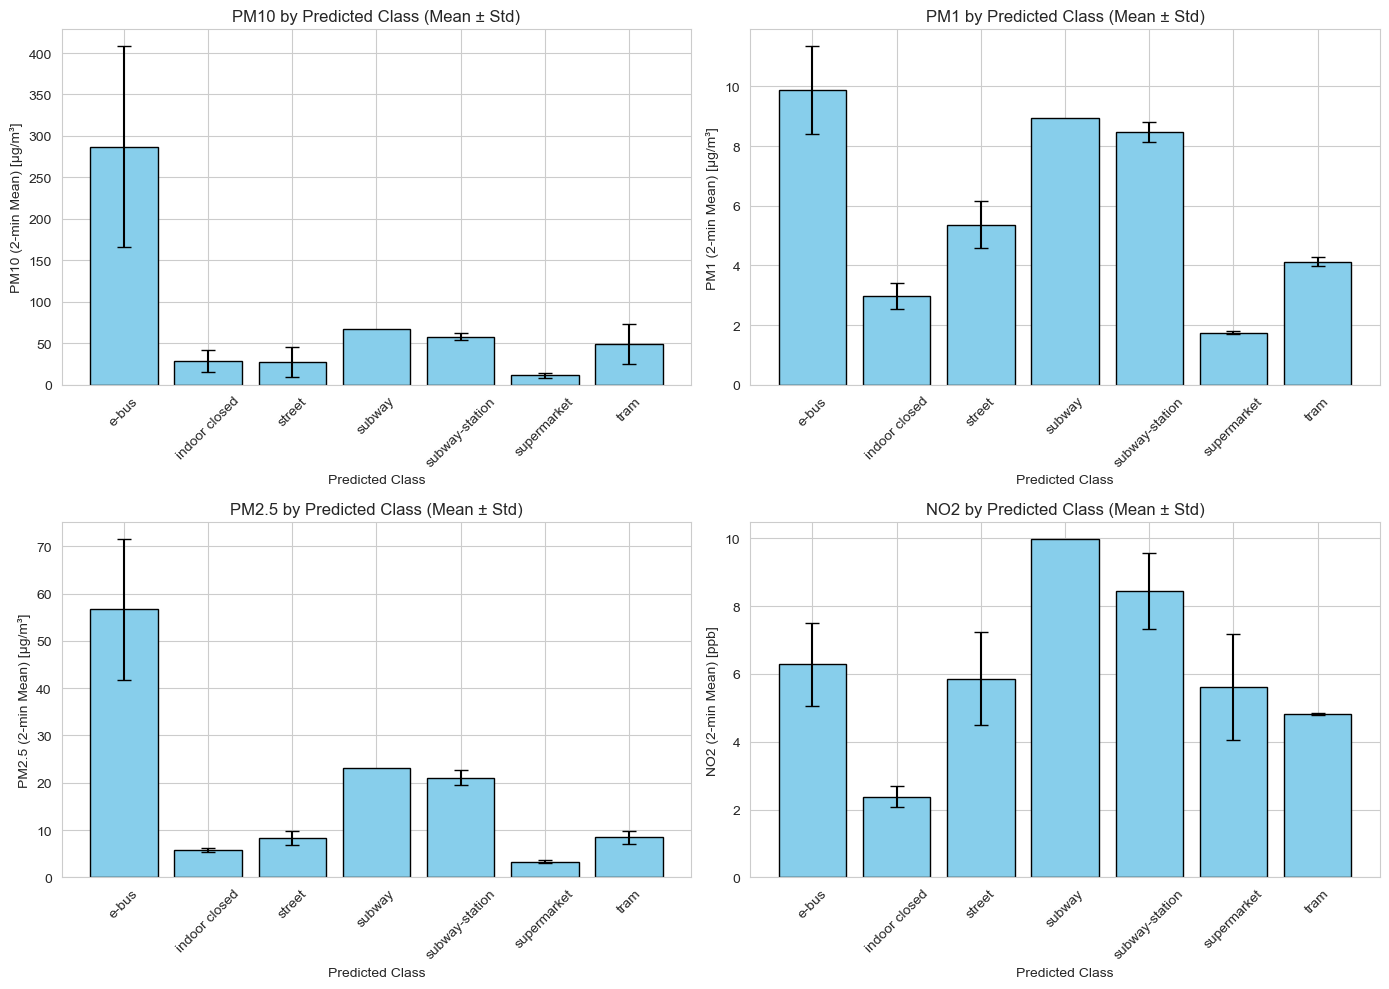

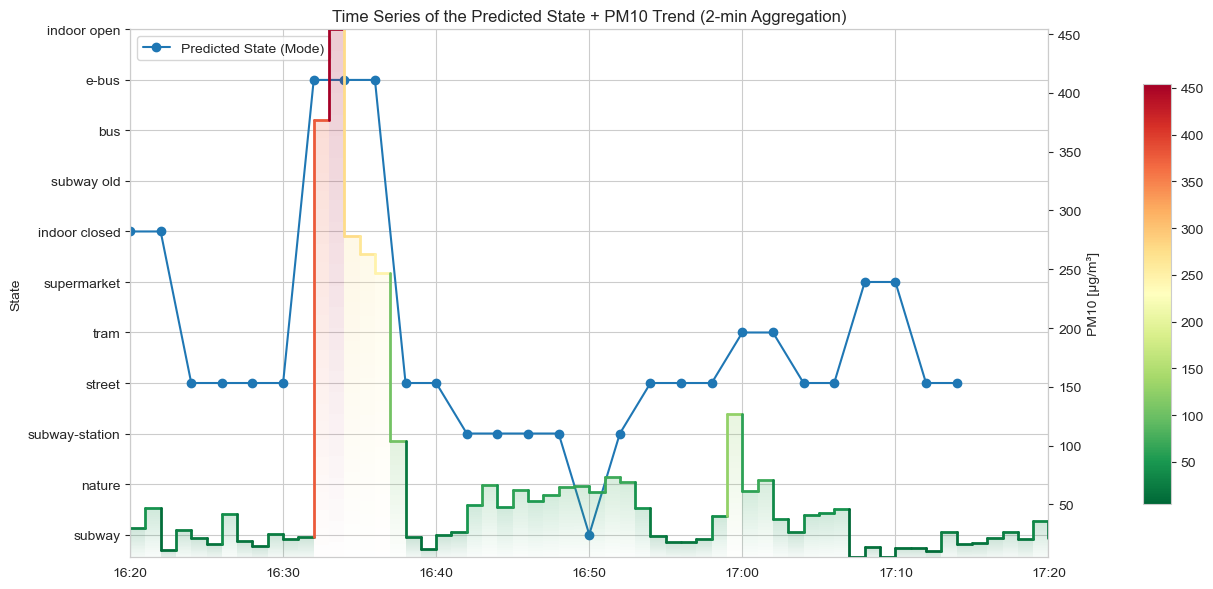

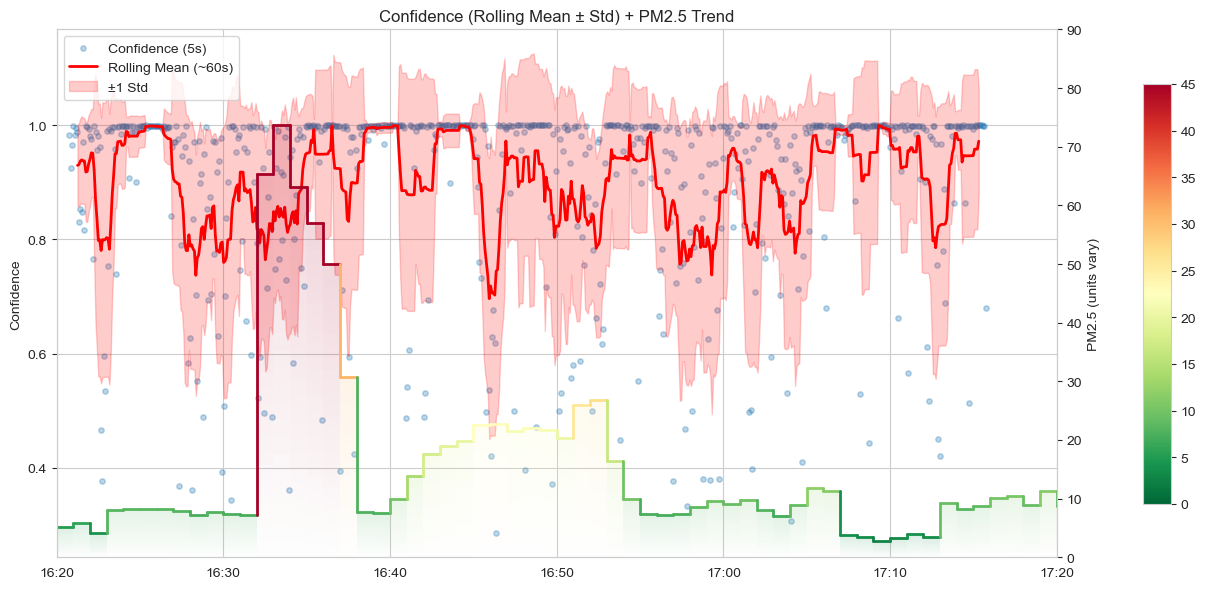

In [1]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

###############################################################################
# 1) GLOBALE EINSTELLUNGEN: PFADANGABEN, LABEL-MAPPINGS ETC.
###############################################################################

# Haupt-CSV-Datei mit Vorhersagen oder rohen Sensordaten (5-Sekunden-Intervallen)
CSV_PATH_CAMPAIGN = r"C:\Users\lpera\Downloads\campaign_02.csv"

# Pfad zum trainierten Keras-Modell
MODEL_PATH = r"C:\Users\lpera\BA_tf_nn_model.keras"

# CSV-Dateien für verschiedene Schadstoffe (Pollutants) und zugehörige Spaltennamen
POLLUTANT_FILES = {
    "PM10": {
        "path": r"C:\Users\lpera\Downloads\PM10_airquix10-data-2025-02-22 18_26_12.csv",
        "col":  "pm10"
    },
    "PM1": {
        "path": r"C:\Users\lpera\Downloads\PM1_airquix10-data-2025-02-22 18_26_05.csv",
        "col":  "pm1"
    },
    "PM2.5": {
        "path": r"C:\Users\lpera\Downloads\PM2.5_airquix10-data-2025-02-22 18_25_56.csv",
        "col":  "pm2.5"
    },
    "NO2": {
        "path": r"C:\Users\lpera\Downloads\NO2_airquix10-data-2025-02-22 19_06_40.csv",
        "col":  "no2_aq10"
    }
}

# Ab wann wir Daten betrachten wollen
MANUAL_START_TIME = pd.Timestamp("2025-02-20 16:20:00")

# Zeitfenster für die Diagramme (Beginn / Ende)
start_plot = pd.Timestamp("2025-02-20 16:20:00")
end_plot   = pd.Timestamp("2025-02-20 17:20:00")

# Einheiten der Schadstoffe (für die Achsenbeschriftung). Hoffentlich korrekt.
units = {
    "PM10":  "µg/m³",
    "PM1":   "µg/m³",
    "PM2.5": "µg/m³",
    "NO2":   "ppb"
}

# Label-Mapping fürs Modell
label_mapping = {
    "vehicle in subway": 0,
    "outdoor in nature": 1,
    "indoor in subway-station": 2,
    "outdoor on foot": 3,
    "vehicle in tram": 4,
    "indoor in supermarket": 5,
    "indoor with window closed": 6,
    "vehicle in subway (old)": 7,
    "vehicle in bus": 8,
    "vehicle in e-bus": 9,
    "indoor with window open": 10
}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Kurze Bezeichnungen für die Diagramme
short_label_mapping = {
    "vehicle in subway":         "subway",
    "outdoor in nature":         "nature",
    "indoor in subway-station":  "subway-station",
    "outdoor on foot":           "street",
    "vehicle in tram":           "tram",
    "indoor in supermarket":     "supermarket",
    "indoor with window closed": "indoor closed",
    "vehicle in subway (old)":   "subway old",
    "vehicle in bus":            "bus",
    "vehicle in e-bus":          "e-bus",
    "indoor with window open":   "indoor open"
}

def get_pred_mode_label(class_id):
    """Gibt ne kurze, schnucklige Bezeichnung für die vorhergesagte Klasse zurück."""
    original_name = inv_label_mapping.get(class_id, "Unknown")
    return short_label_mapping.get(original_name, original_name)

###############################################################################
# 2) HAUPT-CSV LADEN UND MODELL-INFERENZ AUSFÜHREN
###############################################################################
df = pd.read_csv(CSV_PATH_CAMPAIGN, delimiter=",", encoding="utf-8")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Feature-Spalten bestimmen (timestamp/status_gt ausschließen)
FEATURE_COLS = [col for col in df.columns if col not in ["timestamp", "status_gt"]]

# Keras-Modell laden – hoffen wir, dass es das richtige ist
model = tf.keras.models.load_model(MODEL_PATH)
print("Modell erfolgreich geladen. Yuhu.")

# Inferenz alle ~5 Sekunden
predictions = []
for i in range(len(df)):
    input_data = {}
    for col in FEATURE_COLS:
        value = df.loc[i, col]
        if np.issubdtype(df[col].dtype, np.number):
            input_data[col] = np.array([[value]], dtype=np.float32)
        else:
            input_data[col] = tf.convert_to_tensor([[str(value)]], dtype=tf.string)
    pred = model.predict(input_data)
    prob_vector = pred[0]
    pred_class = int(np.argmax(prob_vector))
    confidence = float(prob_vector[pred_class])
    predictions.append((df.loc[i, 'timestamp'], pred_class, confidence))

pred_df = pd.DataFrame(predictions, columns=['timestamp', 'pred_mode_class', 'confidence'])

# Vorhersagen in 2-Minuten-Intervallen zusammenfassen (Modus der Klassen)
pred_df['minute'] = pred_df['timestamp'].dt.floor('2min')
pred_minute = pred_df.groupby('minute').agg(
    pred_mode_class=pd.NamedAgg(column='pred_mode_class', aggfunc=lambda x: x.mode().iloc[0]),
    avg_confidence=pd.NamedAgg(column='confidence', aggfunc='mean')
).reset_index()

# Auf manuell gewählten Startzeitpunkt filtern
pred_minute = pred_minute[pred_minute['minute'] >= MANUAL_START_TIME].copy()

###############################################################################
# 3) HELFER-FUNKTION: CSV LADEN & SCHADSTOFFDATEN IN 2-MIN INTERVALLEN MITTELN
###############################################################################
def load_and_aggregate_2min(csv_path, time_col, value_col):
    """
    Lädt CSV von csv_path, konvertiert time_col zu datetime,
    gruppiert value_col in 2-Minuten-Intervallen (Mittelwert).
    Liefert DataFrame mit Spalten [minute, pollutant_mean].
    Tippfehler absichtli? Naja ;)
    """
    df_poll = pd.read_csv(csv_path, parse_dates=[time_col])
    df_poll.sort_values(by=time_col, inplace=True)
    
    # Nur Daten nach Startzeit
    df_poll = df_poll[df_poll[time_col] >= MANUAL_START_TIME].copy()
    
    # Zeit auf 2-Minuten runden
    df_poll['minute'] = df_poll[time_col].dt.floor('2min')
    
    # Mitteln über jedes 2-Minuten-Intervall
    df_agg = df_poll.groupby('minute')[value_col].mean().reset_index()
    df_agg.rename(columns={value_col: 'pollutant_mean'}, inplace=True)
    return df_agg

###############################################################################
# 4) SCHADSTOFF-DATEN MIT DEN VORHERSAGEN MERGEN & BARPLOTS
###############################################################################
merged_data = {}  # key = "PM10"/"PM1"/"PM2.5"/"NO2", value = DataFrame

for pol_name, info in POLLUTANT_FILES.items():
    csv_path = info["path"]
    col_name = info["col"]
    
    # Daten laden & 2-Minuten-Intervall-Mittelwerte bilden
    df_pol_2min = load_and_aggregate_2min(csv_path, "Time", col_name)
    
    # Mit pred_minute zusammenführen
    merged = pd.merge(
        pred_minute,         # [minute, pred_mode_class, avg_confidence]
        df_pol_2min,         # [minute, pollutant_mean]
        on='minute',
        how='inner'
    )
    merged_data[pol_name] = merged

# Bar-Diagramme: Mittelwert ± Std für jeden vorhergesagten Status
sns.set_style("whitegrid")
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axs = axs.flatten()

for i, (pol_name, df_merged) in enumerate(merged_data.items()):
    ax = axs[i]
    # Kurze Labels
    df_merged['pred_mode_label'] = df_merged['pred_mode_class'].apply(get_pred_mode_label)
    
    # Gruppieren nach pred_mode_label: Mittel & Std
    stats = df_merged.groupby('pred_mode_label')['pollutant_mean'].agg(['mean','std']).reset_index()
    stats.rename(columns={'mean':'pollutant_mean','std':'pollutant_std'}, inplace=True)
    stats.sort_values(by='pred_mode_label', inplace=True)
    
    # Barplot
    ax.bar(
        x=range(len(stats)),
        height=stats['pollutant_mean'],
        yerr=stats['pollutant_std'],
        tick_label=stats['pred_mode_label'],
        capsize=5,
        color='skyblue',
        edgecolor='black'
    )
    pol_unit = units.get(pol_name, "")
    ax.set_title(f"{pol_name} by Predicted Class (Mean ± Std)")
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel(f"{pol_name} (2-min Mean) [{pol_unit}]")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("barplots_pred_state_pollutants_with_units.png", dpi=300, bbox_inches="tight")
plt.show()

###############################################################################
# 5) ZEITREIHEN-PLOTS FÜR JEDE POLLUTANT (PM10, PM1, PM2.5, NO2),
#    ZEIGT NUR DIE VORHERSAGTE KLASSE (KEIN GROUND TRUTH)
###############################################################################
def plot_time_series_classes_and_pollutant(df_poll, time_col, val_col, pol_name):
    """
    Zeichnet die vorhergesagte Klasse (2-min mode) auf der linken Achse,
    und den Schadstoff auf der rechten Achse (Verlauf + Farbverlauf).
    Achtung: Kein ground truth hier enthalten, weil wir "true_minute" nicht definiert haben.
    """
    df_poll_filtered = df_poll[df_poll[time_col] >= MANUAL_START_TIME].copy()

    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

    # Vorhergesagte Klassen vs. Minute (2-min mode)
    ax1.plot(
        pred_minute['minute'],
        pred_minute['pred_mode_class'],
        marker='o', linestyle='-', color='tab:blue',
        label='Predicted State (Mode)'
    )

    ax1.set_ylabel("State")
    ax1.set_title(f"Time Series of the Predicted State + {pol_name} Trend (2-min Aggregation)")

    ax1.legend(loc='upper left')
    all_classes = sorted(label_mapping.values())
    ax1.set_yticks(all_classes)
    ax1.set_yticklabels([
        short_label_mapping.get(inv_label_mapping.get(cls, "Unknown"), "Unknown")
        for cls in all_classes
    ])

    # Rechte Achse für den Schadstoff
    ax2 = ax1.twinx()
    ax2.grid(False)

    # Filter auf den end_plot
    df_poll_filtered = df_poll_filtered[df_poll_filtered[time_col] <= end_plot]
    times_pol = df_poll_filtered[time_col].to_numpy()
    vals_pol  = df_poll_filtered[val_col].to_numpy()

    if len(times_pol) > 0:
        min_val = vals_pol.min()
        max_val = vals_pol.max()
        norm = plt.Normalize(min_val, max_val)
        cmap = plt.get_cmap("RdYlGn_r")
        ax2.set_ylim(min_val, max_val)

        n_stripes = 25
        for i in range(len(vals_pol) - 1):
            x1_ = times_pol[i]
            x2_ = times_pol[i+1]
            y1_ = vals_pol[i]
            y2_ = vals_pol[i+1]

            color_h = cmap(norm(y1_))
            color_v = cmap(norm(y2_))
            ax2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2)
            ax2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2)

            bottom_level = 0
            top_level = y1_
            levels = np.linspace(bottom_level, top_level, n_stripes + 1)
            for s in range(n_stripes):
                bottom = levels[s]
                top = levels[s+1]
                alpha_val = 0.2 * ((s+1)/n_stripes)
                ax2.fill_between(
                    [x1_, x2_], top, bottom,
                    facecolor=color_h, alpha=alpha_val,
                    edgecolor='none'
                )

        pol_unit = units.get(pol_name, "")
        ax2.set_ylabel(f"{pol_name} [{pol_unit}]")
    else:
        print(f"Keine {pol_name}-Daten nach {MANUAL_START_TIME} gefunden. Schade.")
        ax2.set_ylabel(f"{pol_name}")

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.set_xlim(start_plot, end_plot)

    fig.tight_layout(rect=[0, 0, 0.8, 1])
    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    if len(times_pol) > 0:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
    else:
        sm = plt.cm.ScalarMappable()
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)

    fig.autofmt_xdate(rotation=45)
    plt.savefig(f"{pol_name}_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

###############################################################################
# 6) OPTIONAL: CONFIDENCE (ROLLING MEAN ± STD) VS. POLLUTANT
###############################################################################
def plot_confidence_vs_pollutant(pred_df, df_poll, pol_name, pol_col):
    """
    Zeichnet den gleitenden Mittelwert & Std der Vorhersage-Confidence
    auf der linken Achse, sowie den Schadstoff auf der rechten Achse (Farbverlauf).
    """
    pdf = pred_df[pred_df['timestamp'] >= MANUAL_START_TIME].copy()
    pdf['confidence_smooth'] = pdf['confidence'].rolling(window=12, center=True).mean()
    pdf['confidence_std'] = pdf['confidence'].rolling(window=12, center=True).std()

    dfp = df_poll[df_poll['Time'] >= MANUAL_START_TIME].copy()
    times_pol = dfp['Time'].to_numpy()
    vals_pol  = dfp[pol_col].to_numpy()

    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Confidence: Scatter
    ax1.scatter(
        pdf['timestamp'],
        pdf['confidence'],
        color='tab:blue', marker='o', s=15, alpha=0.3,
        label='Confidence (5s)'
    )
    # Rolling mean
    ax1.plot(
        pdf['timestamp'],
        pdf['confidence_smooth'],
        color='red', linewidth=2,
        label='Rolling Mean (~60s)'
    )
    # ±1 std
    ax1.fill_between(
        pdf['timestamp'],
        pdf['confidence_smooth'] - pdf['confidence_std'],
        pdf['confidence_smooth'] + pdf['confidence_std'],
        color='red', alpha=0.2, label='±1 Std'
    )

    ax1.set_ylabel("Confidence")
    ax1.set_title(f"Confidence (Rolling Mean ± Std) + {pol_name} Trend")
    ax1.legend(loc='upper left')

    # Rechte Achse für den Schadstoff
    ax2 = ax1.twinx()
    ax2.grid(False)

    if len(times_pol) > 1:
        cmap = plt.get_cmap("RdYlGn_r")
        # Beispiel: clamp von 0..45 (da wir keinen Schimmer haben, ob's realistisch ist)
        norm = plt.Normalize(0, 45)
        # Achse auf 0..90, total random
        ax2.set_ylim(0, 90)

        n_stripes = 25
        for i in range(len(vals_pol) - 1):
            x1_ = times_pol[i]
            x2_ = times_pol[i+1]
            y1_ = vals_pol[i]
            y2_ = vals_pol[i+1]

            color_h = cmap(norm(min(y1_, 45)))
            color_v = cmap(norm(min(y2_, 45)))
            ax2.plot([x1_, x2_], [y1_, y1_], color=color_h, linewidth=2, zorder=2)
            ax2.plot([x2_, x2_], [y1_, y2_], color=color_v, linewidth=2, zorder=2)

            bottom_level = 0
            top_level = y1_
            if top_level < 0:
                top_level = 0
            levels = np.linspace(bottom_level, top_level, n_stripes + 1)
            for s in range(n_stripes):
                bottom = levels[s]
                top = levels[s+1]
                alpha_val = 0.15 * ((s+1)/n_stripes)
                ax2.fill_between(
                    [x1_, x2_], top, bottom,
                    facecolor=color_h, alpha=alpha_val,
                    edgecolor='none',
                    zorder=1
                )

        ax2.set_ylabel(f"{pol_name} (units vary)")
    else:
        print(f"Keine {pol_name}-Daten nach {MANUAL_START_TIME}. Sorry!")
        ax2.set_ylabel(f"{pol_name}")

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.set_xlim(start_plot, end_plot)
    fig.tight_layout(rect=[0, 0, 0.8, 1])

    cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    if len(times_pol) > 1:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
    else:
        sm = plt.cm.ScalarMappable()
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)

    fig.autofmt_xdate(rotation=45)
    plt.savefig(f"{pol_name}_confidence_rolling.png", dpi=300, bbox_inches="tight")
    plt.show()

###############################################################################
# 7) BEISPIELVERWENDUNG:
#    - Zeitreihenplots für jeden Schadstoff
#    - Confidence vs. Schadstoff
###############################################################################
if __name__ == "__main__":
    # Beispiel: Zeitreihenplot für PM10
    df_pm10 = pd.read_csv(POLLUTANT_FILES["PM10"]["path"], parse_dates=["Time"]).sort_values(by="Time")
    plot_time_series_classes_and_pollutant(
        df_poll=df_pm10,
        time_col="Time",
        val_col="pm10",
        pol_name="PM10"
    )

    # Beispiel: Confidence vs. PM2.5
    df_pm25 = pd.read_csv(POLLUTANT_FILES["PM2.5"]["path"], parse_dates=["Time"]).sort_values(by="Time")
    plot_confidence_vs_pollutant(
        pred_df=pred_df,
        df_poll=df_pm25,
        pol_name="PM2.5",
        pol_col="pm2.5"
    )

    # Ähnlich könnt ihr plot_time_series_classes_and_pollutant
    # oder plot_confidence_vs_pollutant für "PM1" oder "NO2" verwenden.
    pass
